In [ ]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
# Load image and convert to tensor
def load_image(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape:
        size = shape
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255)
    ])
    image = transform(image).unsqueeze(0)
    return image

# Display tensor as image
def show_image(tensor, title=None):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image / 255
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Gram matrix for style calculation
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())


In [ ]:
import urllib.request

# Content image (photo)
urllib.request.urlretrieve(
    'https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg',
    'content.jpg'
)

# Style image (artwork)
urllib.request.urlretrieve(
    'https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg',
    'style.jpg'
)


('style.jpg', <http.client.HTTPMessage at 0x7e48c943b5f0>)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

content = load_image('content.jpg').to(device)
style = load_image('style.jpg', shape=[content.size(2), content.size(3)]).to(device)


In [ ]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

content_layers = ['conv4_2']
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']

def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        layer_name = f'conv{name}'
        if layer_name in layers:
            features[layer_name] = x
    return features


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 82.9MB/s]


In [ ]:
target = content.clone().requires_grad_(True).to(device)

content_features = get_features(content, vgg, content_layers)
style_features = get_features(style, vgg, style_layers)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weight = 1e6
content_weight = 1
optimizer = optim.Adam([target], lr=0.003)


Step 50, Loss: 791111769522176.00


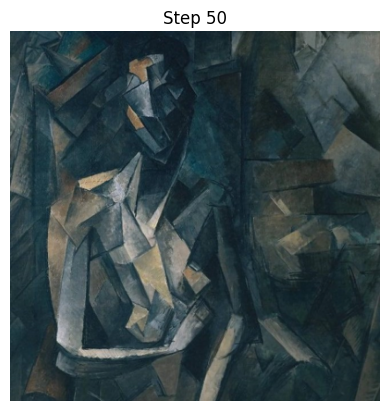

Step 100, Loss: 759366860931072.00


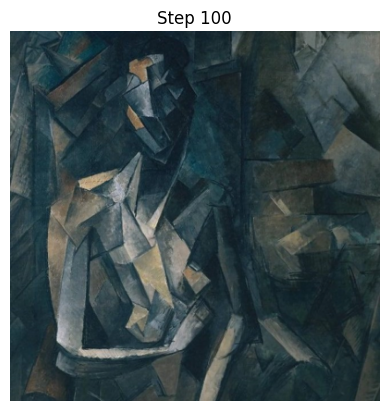

Step 150, Loss: 730271812943872.00


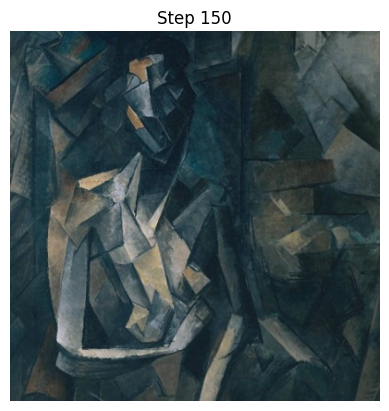

Step 200, Loss: 703413100740608.00


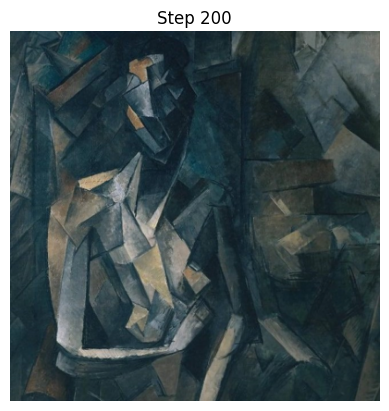

Step 250, Loss: 678535710638080.00


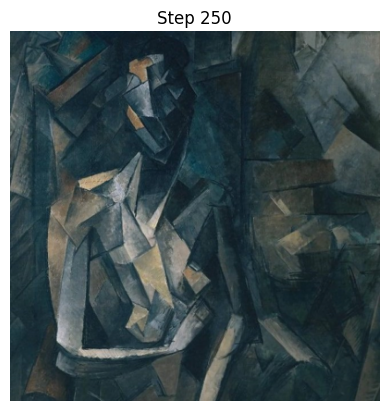

Step 300, Loss: 655391406948352.00


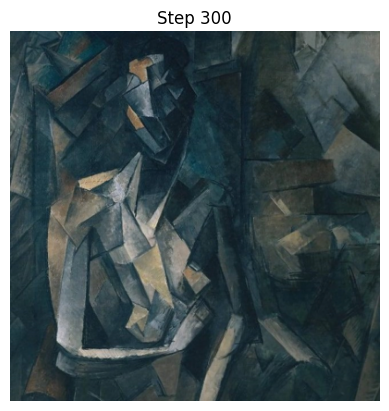

In [ ]:
# Redefine get_features function to correctly extract features from VGG19
def get_features(image, model, layers_to_extract):
    features = {}
    x = image
    # Map Sequential module indices to semantic VGG layer names (Convolutional layers only)
    vgg_layer_names = {
        '0': 'conv1_1', '2': 'conv1_2',
        '5': 'conv2_1', '7': 'conv2_2',
        '10': 'conv3_1', '12': 'conv3_2', '14': 'conv3_3', '16': 'conv3_4',
        '19': 'conv4_1', '21': 'conv4_2', '23': 'conv4_3', '25': 'conv4_4',
        '28': 'conv5_1', '30': 'conv5_2', '32': 'conv5_3', '34': 'conv5_4'
    }
    for name, layer in model._modules.items(): # model here is vgg.features (Sequential)
        x = layer(x)
        if name in vgg_layer_names:
            semantic_name = vgg_layer_names[name]
            if semantic_name in layers_to_extract:
                features[semantic_name] = x
    return features

# Re-compute content_features, style_features, and style_grams using the corrected get_features
# These lines were originally in a previous cell (M7gI132Tgukh) and need to be re-run.
content_features = get_features(content, vgg, content_layers)
style_features = get_features(style, vgg, style_layers)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


steps = 300  # You can increase for stronger results

for i in range(1, steps+1):
    target_features = get_features(target, vgg, content_layers + style_layers)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss
    style_loss = 0
    for layer in style_layers:
        # Corrected: Access style_grams directly with 'layer' as it's already the correct key
        style_gram = style_grams[layer]
        target_gram = gram_matrix(target_features[f'conv{layer[-3:]}']) # This mapping seems correct assuming 'layer' is e.g., 'conv1_1'
        style_loss += torch.mean((target_gram - style_gram)**2) / target_features[f'conv{layer[-3:]}'].nelement()

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f'Step {i}, Loss: {total_loss.item():.2f}')
        show_image(target, title=f'Step {i}')


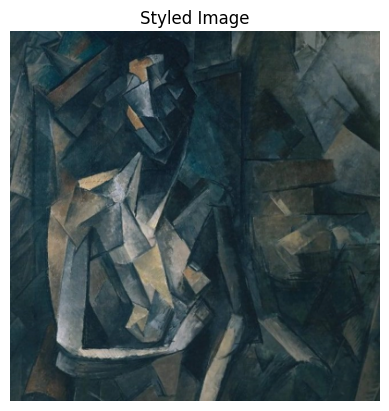

In [ ]:
show_image(target, title='Styled Image')
